# Imports

In [1]:
!pip install torch-summary

In [2]:
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from torchsummary import summary
from torchvision import datasets, transforms

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Prepare the Dataset
As before, you will load the train and test sets from TFDS. Notice that we don't flatten the image this time. That's because we will be using convolutional layers later that can deal with 2D images.


In [4]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_set = datasets.MNIST('MNIST/', train=True, download=True, transform=transform)

batch_size = 128
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 100598161.67it/s]


Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 51878241.47it/s]


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 22602651.17it/s]


Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8766925.34it/s]


Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



# Define the Model
As mentioned, you will use convolutional layers to build the model. This is composed of three main parts: encoder, bottleneck, and decoder. You will follow the configuration shown in the image below.
<img src="https://drive.google.com/uc?export=view&id=15zh7bst9KKvciRdCvMAH7kXt3nNkABzO" width="75%" height="75%"/>

The encoder, just like in previous labs, will contract with each additional layer. The features are generated with the Conv2D layers while the max pooling layers reduce the dimensionality.

In [5]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.conv1(x); x = self.relu(x)
        x = self.maxpool1(x); 
        x = self.conv2(x); x = self.relu(x) 
        x = self.maxpool2(x) 
        return x

class Bottleneck(nn.Module): 
    def __init__(self):
        super().__init__() 
        self.bottleneck = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.encoder_visualization = nn.Conv2d(in_channels=256, out_channels=1, kernel_size=3, padding=1) 
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x): 
        bottleneck_output = self.bottleneck(x) 
        bottleneck_output = self.relu(bottleneck_output)
        
        visualization = self.encoder_visualization(bottleneck_output)
        visualization = self.sigmoid(visualization) 
        
        return bottleneck_output, visualization
    
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1) 
        self.upsample1 = nn.Upsample(scale_factor=2) 
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.upsample2 = nn.Upsample(scale_factor=2) 
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.conv1(x); x = self.relu(x)
        x = self.upsample1(x)
        x = self.conv2(x); x = self.relu(x)
        x = self.upsample2(x)
        x = self.conv3(x); x = self.sigmoid(x)
        return x
            

In [6]:
class AutoEncoder(nn.Module):
    def __init__(self, encoder, bottleneck, decoder):
        super().__init__()
        self.encoder = encoder
        self.bottleneck = bottleneck
        self.decoder = decoder
    
    def forward(self, x):
        x = self.encoder(x)
        x,_ = self.bottleneck(x)
        x = self.decoder(x)
        return x

In [7]:
encoder = Encoder().to(device)
bottleneck = Bottleneck().to(device)
decoder = Decoder().to(device)

autoencoder = AutoEncoder(encoder, bottleneck, decoder).to(device)

summary(autoencoder, (1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Encoder: 1-1                           [-1, 128, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 28, 28]          640
|    └─ReLU: 2-2                         [-1, 64, 28, 28]          --
|    └─MaxPool2d: 2-3                    [-1, 64, 14, 14]          --
|    └─Conv2d: 2-4                       [-1, 128, 14, 14]         73,856
|    └─ReLU: 2-5                         [-1, 128, 14, 14]         --
|    └─MaxPool2d: 2-6                    [-1, 128, 7, 7]           --
├─Bottleneck: 1-2                        [-1, 256, 7, 7]           --
|    └─Conv2d: 2-7                       [-1, 256, 7, 7]           295,168
|    └─ReLU: 2-8                         [-1, 256, 7, 7]           --
|    └─Conv2d: 2-9                       [-1, 1, 7, 7]             2,305
|    └─Sigmoid: 2-10                     [-1, 1, 7, 7]             --
├─Decoder: 1-3                           [-1, 1, 28, 28]           --
| 

Layer (type:depth-idx)                   Output Shape              Param #
├─Encoder: 1-1                           [-1, 128, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 28, 28]          640
|    └─ReLU: 2-2                         [-1, 64, 28, 28]          --
|    └─MaxPool2d: 2-3                    [-1, 64, 14, 14]          --
|    └─Conv2d: 2-4                       [-1, 128, 14, 14]         73,856
|    └─ReLU: 2-5                         [-1, 128, 14, 14]         --
|    └─MaxPool2d: 2-6                    [-1, 128, 7, 7]           --
├─Bottleneck: 1-2                        [-1, 256, 7, 7]           --
|    └─Conv2d: 2-7                       [-1, 256, 7, 7]           295,168
|    └─ReLU: 2-8                         [-1, 256, 7, 7]           --
|    └─Conv2d: 2-9                       [-1, 1, 7, 7]             2,305
|    └─Sigmoid: 2-10                     [-1, 1, 7, 7]             --
├─Decoder: 1-3                           [-1, 1, 28, 28]           --
| 

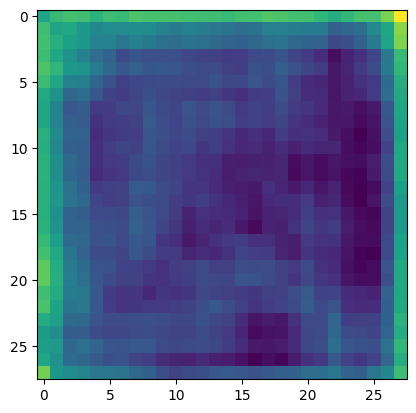

In [8]:
# Testing
sample_data = torch.rand((1,1,28,28)).to(device)
with torch.inference_mode(): 
    y = autoencoder(sample_data)

tes = y.squeeze(dim=0)
plt.imshow(tes[0].cpu())
plt.show()

# Compile and Train the model

In [9]:
optimizer = torch.optim.Adam(params=autoencoder.parameters())
loss_fn = nn.BCELoss()

In [10]:
# Training loop

losses = []
epochs = 10

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        # Forward pass
        outputs = autoencoder(inputs)
        loss = loss_fn(outputs, inputs)

        optimizer.zero_grad(); loss.backward(); optimizer.step()
        running_loss += loss.item()
    
    avg_loss = running_loss/len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch} | Loss: {avg_loss}")

Epoch 0 | Loss: 0.10186408121766312
Epoch 1 | Loss: 0.06982156448463388
Epoch 2 | Loss: 0.06762387735375971
Epoch 3 | Loss: 0.06650566632178292
Epoch 4 | Loss: 0.06577218234189537
Epoch 5 | Loss: 0.0651748803918804
Epoch 6 | Loss: 0.06470790330662148
Epoch 7 | Loss: 0.06431147622178866
Epoch 8 | Loss: 0.06398180082662781
Epoch 9 | Loss: 0.06368873259628505


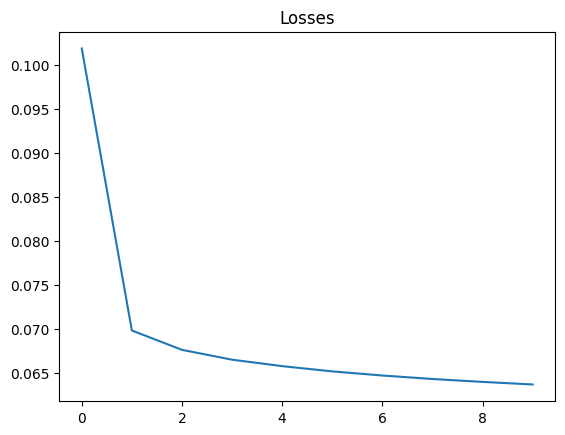

In [11]:
plt.plot(losses)
plt.title("Losses")
plt.show()

## Display sample results

You can now visualize the results. The utility functions below will help in plotting the encoded and decoded values.

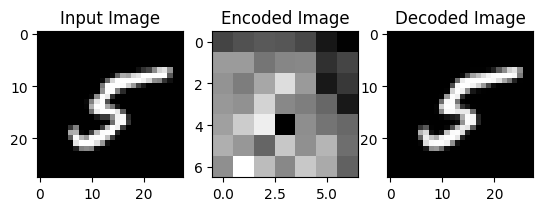

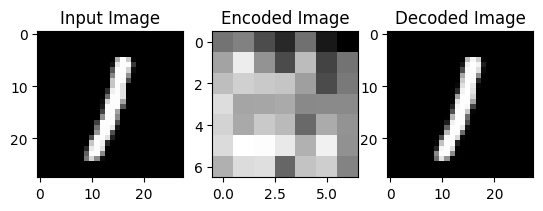

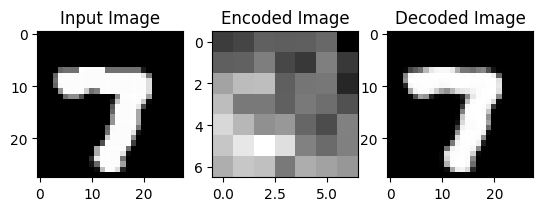

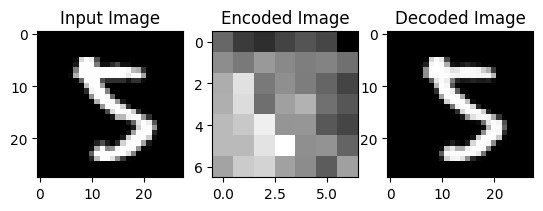

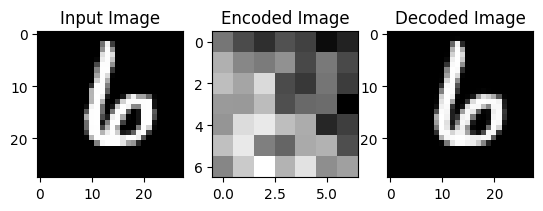

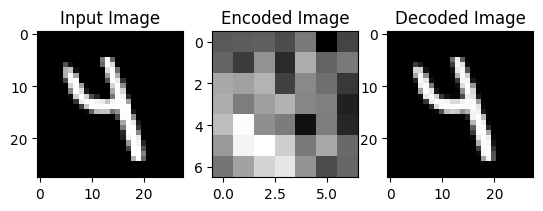

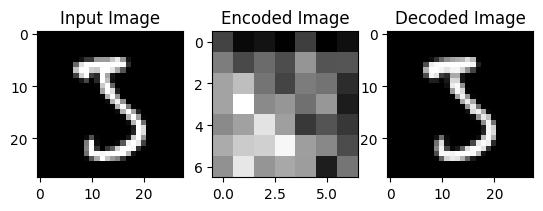

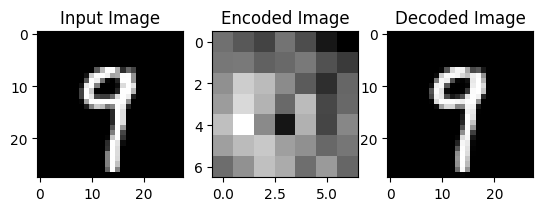

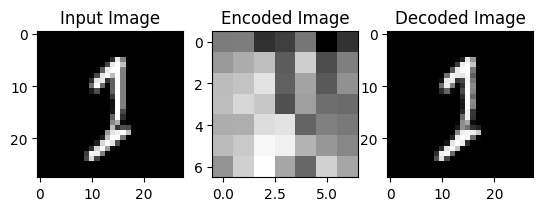

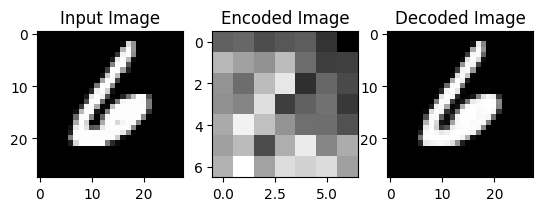

In [12]:
image, label = next(iter(train_loader))
sample = image[0:10]

for i, img in enumerate(sample, 0):
    img = img.unsqueeze(dim=0).to(device)
    with torch.inference_mode():
        encoded = encoder(img) 
        bottleneck_out, encoded_vis = bottleneck(encoded)
        decoded = decoder(bottleneck_out)
        
        

    encoded_image = encoded_vis.squeeze(dim=0)[0]
    decoded_image = decoded.squeeze(dim=0)[0]
    
    plt.subplot(1,3,1)
    plt.imshow(img.cpu().squeeze(dim=0)[0], cmap='gray')
    plt.title('Input Image')

    plt.subplot(1,3,2)
    plt.imshow(encoded_image.cpu(), cmap='gray')
    plt.title('Encoded Image')

    plt.subplot(1,3,3)
    plt.imshow(decoded_image.cpu(), cmap='gray')
    plt.title('Decoded Image')
    plt.show()
